# Objective and Forecast 


	- Business Problem: Predict a favorable (profitable) out for the winner between two fighters at an UFC event. 
	- ML Problem: Binary Classification (either one person wins or the other)
	- Metrics: Confusion matrix, Log Loss, and ROC-AUC curve

### The Data and Sources 

For a more detailed breakdown of the data, please scroll to the EDA section. This section will contain a quick preface of the structure of the data, and any outside sources to be credited. 

#### The Features 

The features contain a total of 118 columns that each fall in one of the following categories:

	- Identification variables: fighter names, dates, locations
	- Fighters' physical attributes: reach, height, weight, gender, weight class
	- Fighters' skill attributes: significant strike percentage, submissions and takedowns, win-loss record, win-loss streaks, ranking
	- Bout-specific details: total fight time, who won/how did they win (ect. Red - Unanimous Decision, or Blue - KO/TKO)

#### The Target

What we're trying to predict is the winner of each bout, presented in the train set as the 'Winner' column, with class levels being either 'Red' or 'Blue' (the colors of the corners in the UFC octagon - depending on which corner is whose, the fighter is either classified as a 'Red' fighter or 'Blue' fighter).

Before training, I encoded these values as 0 and 1, with 'Red' being the former. Because there is a disproportionately large number of 'Red' winners, there were more 0's than 1's, and I had to be careful with the fact that features that seem less significant might be skewed towards the 0 side. 

### Quick Note 

## Overview of the Project

### What I worked with - Insights from EDA

	- Between the 118 numerical and categorical features, there was a high amount of dimensionality that had to be reduced. A lot of the columns were circumstantial (if one was nonzero, the others were not), and had a large amount of nulls 
	- The dataset is imbalanced, erring in favor of fighters from the Red corner
	- A few of the continuous variables like height and reach are collinear, and so are a lot of the ordinal variables, creating a lot of noise  

### What I tried - Approaches and Models

I tried a total of 7 feature engineering approaches, and 3 total models.

Feature engineering approaches: 
	
	- Looking at all columns (ordinal, encoded categorical, and continuous) and using those that have the highest correlation with the target column
	- Finding a mix of ordinal and continous features that are skewed towards one outcome, or normaly distributed
	- Reducing dimensionality by consolidating variables unique to each fighter into one variable indexing the difference

Models:

	- Ensemble methods like Random Forest, Gradient Boosting, etc. 
		- Able to handle imbalanced data, and data that skews one way
		- Able to handle complex datasets with high dimensionality, robust to outliers 
		- Particularly sensitive to features with more probabilistic pull on the outcome
	- Probabilistic models like Naive Bayes
		- A probabilistic estimate 
		- Easily interpretable
		- Fast and useful for real-time prediciton
	- SVM
		- I thought there'd be a chance, if there was some sort of linear correlation, SVM could handle the high dimensionality through composition analysis
		- This ended up being a bust...


### What worked and how I could tell - The best model, features, and hyperparameters

The best arrangement of features was actually a mix between the approaches. I picked a number of features that were normally distributed or heavily favored one outcome, and I also created a new variable called `perf_diff` which was the difference of each fighter's cumulative performance score (computed by aggregating their signifcant strike percentage, total takedown percentage, and total submissions attempted). 

The best model ended up being a random forest classifier - I figured this out by using four particular metrics:

	- Accuracy - across the board, the total number of correct predictions as a proportion of all. Worst is 0, best is 1. 
	- Precision - interpreted using the confusion matrix. The number of true positive predictions as a proportion of all positive predictions. Worst is 0, best is 1.  
	- F1-score - a harmonic mean of precision and recall (true positive predictions as a proportion of ALL predictions). Worst is 0, best is 1. 
	- Log Loss - a loss metric particularly effective for probabilistic outcomes. Best is 0, worst is 1. 

I used these metrics to discern the best hyperparameters for my particular instance of this algorithm. 

Finally, I used the trajectory of the ROC-AUC curve to set a probability threshold to fully maximize the potential of my model. 

# EDA and Feature Engineering Concerns 

NOTE: This dataset has over 100 features, and though I spent the majority of this project plotting different combinations, their correlations, and finding their benefits and drawbacks, for the sake of brevity I've presented only the insights that were the most significant. 

In [28]:
import numpy as np 
import pandas as pd
from helpers import * 
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
ufc = pd.read_csv('ufc-master.csv')

In [29]:
ufc.head()

,R_fighter,B_fighter,R_odds,B_odds,R_ev,B_ev,date,location,country,Winner,...,finish_details,finish_round,finish_round_time,total_fight_time_secs,r_dec_odds,b_dec_odds,r_sub_odds,b_sub_odds,r_ko_odds,b_ko_odds
0,Thiago Santos,Johnny Walker,-150.0,130,66.666667,130.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Red,...,NaN,5.0,5:00,1500.0,800.0,900.0,2000.0,1600.0,-110.0,175.0
1,Alex Oliveira,Niko Price,170.0,-200,170.000000,50.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Blue,...,NaN,3.0,5:00,900.0,450.0,350.0,700.0,1100.0,550.0,120.0
2,Misha Cirkunov,Krzysztof Jotko,110.0,-130,110.000000,76.923077,2021-10-02,"Las Vegas, Nevada, USA",USA,Blue,...,NaN,3.0,5:00,900.0,550.0,275.0,275.0,1400.0,600.0,185.0
3,Alexander Hernandez,Mike Breeden,-675.0,475,14.814815,475.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Red,...,Punch,1.0,1:20,80.0,175.0,900.0,500.0,3500.0,110.0,1100.0
4,Joe Solecki,Jared Gordon,-135.0,115,74.074074,115.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Blue,...,NaN,3.0,5:00,900.0,165.0,200.0,400.0,1200.0,900.0,600.0


In [30]:
ufc.shape

(4896, 119)

## Handling Nulls 

Initially, I tried to handle nulls in a balanced way - initially by filling null values with aggregate statistics (the mean for a continuous feature's nulls, and the mode for categorical features). I also tried to proportion null values to better suit trends from that particular feature or other related features. Ultimately, however, I found it was best to simply drop the null values entirely, because it didn't affect any of the features' trends or omit a significant amount of information. 

I also found the rank variables useless because they 

In [31]:
bad_cols = []

### Columns with more than half their values as nulls

for col in ufc.columns:
    if ufc[col].isna().sum() > ufc.shape[0] // 2:
        bad_cols.append(col) 

In [32]:
bad_cols

['B_match_weightclass_rank',
 'R_match_weightclass_rank',
 "R_Women's Flyweight_rank",
 "R_Women's Featherweight_rank",
 "R_Women's Strawweight_rank",
 "R_Women's Bantamweight_rank",
 'R_Heavyweight_rank',
 'R_Light Heavyweight_rank',
 'R_Middleweight_rank',
 'R_Welterweight_rank',
 'R_Lightweight_rank',
 'R_Featherweight_rank',
 'R_Bantamweight_rank',
 'R_Flyweight_rank',
 'R_Pound-for-Pound_rank',
 "B_Women's Flyweight_rank",
 "B_Women's Featherweight_rank",
 "B_Women's Strawweight_rank",
 "B_Women's Bantamweight_rank",
 'B_Heavyweight_rank',
 'B_Light Heavyweight_rank',
 'B_Middleweight_rank',
 'B_Welterweight_rank',
 'B_Lightweight_rank',
 'B_Featherweight_rank',
 'B_Bantamweight_rank',
 'B_Flyweight_rank',
 'B_Pound-for-Pound_rank',
 'finish_details']

We'll drop these columns entirely.

## Imbalanced Data  

In [6]:
ufc.Winner.value_counts()

Winner
Red     2859
Blue    2037
Name: count, dtype: int64

We will have to resample this with replacement. Some of the models we'll be looking at are able to handle imbalanced data, but it's definitely helpful to make sure the data is balanced for the sake of the model and for accurate insights from EDA. 

In [33]:
targ = [0 if victor == 'Red' else 1 for victor in ufc['Winner']]
feats = ufc.drop(['Winner'], axis=1)

In [34]:
feats_rs, targ_rs = resample_dataframe(feats, targ)

In [35]:
ufc_rs = feats_rs.copy()
ufc_rs['Winner'] = targ_rs

## The Odds 

In [36]:
red_wins = ufc_rs[ufc_rs['Winner'] == 0]
blue_wins = ufc_rs[ufc_rs['Winner'] == 1]

(Tabset here for odds)

When Red is the underdog, it's more likely to win. Let's take a quick look at what the categorical columns entail. 

## Categorical Columns

In [37]:
num, cat = num_and_cat(ufc_rs)

In [38]:
cat

['R_fighter',
 'B_fighter',
 'date',
 'location',
 'country',
 'title_bout',
 'weight_class',
 'gender',
 'B_Stance',
 'R_Stance',
 'better_rank',
 'finish',
 'finish_details',
 'finish_round_time']

Fighters' names, the date, location, country, and gender are identification variables. Since most UFC fights happen in Las Vegas, there's a disproportionately large amount of events happening there. The date is most likely a non-factor, and gender is consistent for either fighter (no inter-gender fights). Weight class, title bout, and better rank are probably our best bets for a reasonable correlation since logically they could be condusive to better winning situations

	- If a fighter has a better rank, we generally assume that fighter is more skilled and likely to win
	- Different weight classes may have different trends. For example, heavyweight has much more variability than the lighter weight classes, since raw power of heavyweight fighters is more due to their stature, regardless of skill (so 'a puncher's chance' is much higher)
	- If a fight is a title bout, it has different implications than a normal fight for a fighter. This influences their preparation, mentality, and tenacity in the fight. In addition, title fights are 5 rounds, whereas non-title bouts are 3. This marks a significant step up in stamina concerns. 

In [39]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for col in cat:
    if col in ufc_rs.columns:
        ufc_rs[col] = le.fit_transform(ufc_rs[col])

(Another tabset of graphs - these weren't all that helpful)

## High Correlation

In [40]:
corr_dict = {}

for col in ufc_rs.columns:
    corr_dict[col] = ufc_rs[col].corr(ufc_rs['Winner'])

In [41]:
sorted_correlation = sorted(corr_dict.items(), key=lambda x: x[1], reverse=True)

# Extract the top 15 column names
top_15_columns = [column for column, correlation in sorted_correlation[:15]]

# Print the result
print("Top 15 columns based on correlation values:")
print(top_15_columns)

top_15_columns.append('Winner')

Top 15 columns based on correlation values:
['R_odds', 'R_ev', 'R_losses', 'R_win_by_Decision_Split', 'R_current_lose_streak', 'B_current_win_streak', 'B_avg_TD_landed', 'B_Reach_cms', 'weight_class', 'R_total_rounds_fought', 'B_Height_cms', 'B_avg_SIG_STR_landed', 'R_win_by_TKO_Doctor_Stoppage', 'B_Weight_lbs', 'R_win_by_Decision_Majority']


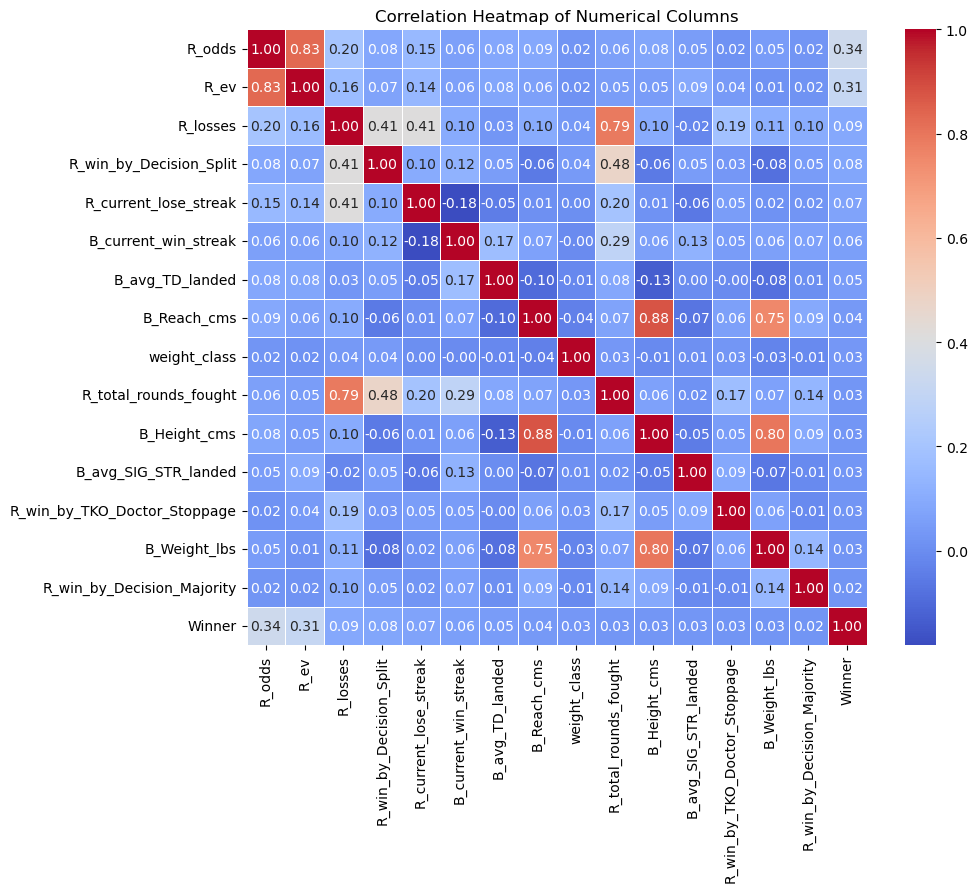

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

def corr_heatmap(df, cols):
    
    heatmap_data = df[cols]
    correlation_matrix = heatmap_data.corr()
    
    plt.figure(figsize=(10,8))
    
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Heatmap of Numerical Columns')
    plt.show()

corr_heatmap(ufc_rs, top_15_columns)

Odds and EV for the red corner are expectedly the most correlated with the winner value. We also have some expected collinearity with the weight variables (fighters must weigh in at roughly the same weight for fights), weight, reach, and height (the bigger you are, the heavier you are), and so on. Another thing to notice is that the performance details (significant strikes, takedown percentage, etc.) are all negatively correlated with the target, with a similar degree of significance. It may be useful to reduce dimensionality by combining these. 

Finally, a lot of features are mirrors of each other (red side vs blue side). We may benefit from combining them into one variable using a difference. 

## Performance Index - Difference 

Include a tabset here describing the individual features combined into `perf_diff`, since this is probably the most important feature transformation done. 

## Insights

It can be seen that - at least as far as this data set goes - the features are anchored against a Blue win (remember - a Red win is encoded as 0 and a Blue win is encoded as 1, so the lower the correlation, the more it tends to a red win). Since we're predicting betting odds, we want to maximize the proportion of predicted favorable bets that are actually favorable. This can be measured with the precision metric. However, we have to consider managing the variabiltiy of the dataset since it's so dimensionally complex. We can do this by leveraging both the precision metric and the F1-score (which is a harmonic mean of the precision and recall values). This will ensure attempting to find a balnce between making accurate positive predictions and capturing as many favorable bets as possible. 

# Model Testing and Feature Selection 

## Preparation 

In [43]:
AD = data_prep_and_feat_engineering(ufc, cat_thresh=0.001, squared_thresh=0.0625)

baseline_feats, baseline_targ = break_down_bundle(AD['approach 1'])

best_approach = ufc.copy() ## creating a new copy of the data to manipulate
best_cols = AD['approach 6'][1] ## features from approach 6
best_approach, best_cols = performance_index(best_approach, best_cols, diff=True) ## creating performance index difference variable

In [44]:
best_approach.head()

,R_fighter,B_fighter,R_odds,B_odds,R_ev,B_ev,date,location,country,Winner,...,total_fight_time_secs,r_dec_odds,b_dec_odds,r_sub_odds,b_sub_odds,r_ko_odds,b_ko_odds,R_perf_idx,B_perf_idx,perf_diff
0,Thiago Santos,Johnny Walker,-150.0,130,66.666667,130.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Red,...,1500.0,800.0,900.0,2000.0,1600.0,-110.0,175.0,0.608276,1.355765,-0.747489
1,Alex Oliveira,Niko Price,170.0,-200,170.000000,50.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Blue,...,900.0,450.0,350.0,700.0,1100.0,550.0,120.0,0.804363,0.929946,-0.125583
2,Misha Cirkunov,Krzysztof Jotko,110.0,-130,110.000000,76.923077,2021-10-02,"Las Vegas, Nevada, USA",USA,Blue,...,900.0,550.0,275.0,275.0,1400.0,600.0,185.0,1.823102,0.541941,1.281161
3,Alexander Hernandez,Mike Breeden,-675.0,475,14.814815,475.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Red,...,80.0,175.0,900.0,500.0,3500.0,110.0,1100.0,0.502096,0.340000,0.162096
4,Joe Solecki,Jared Gordon,-135.0,115,74.074074,115.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Blue,...,900.0,165.0,200.0,400.0,1200.0,900.0,600.0,1.007373,0.682422,0.324951


In [45]:
### dropping nulls
best_approach = best_approach.dropna(subset=best_cols)
print(f"Information loss : {ufc.shape[0] - best_approach.shape[0]} entries")
print(f"Remaining information: {best_approach.shape[0]} entries")

Information loss : 954 entries
Remaining information: 3942 entries


In [46]:
### encoding and separating target, creating features 

best_feats = best_approach[best_cols]
targ = [0 if victor == 'Red' else 1 for victor in best_approach['Winner']]

In [47]:
### resampling 

best_feats_rs, best_targ_rs = resample_dataframe(best_feats, targ)
baseline_feats_rs, baseline_targ_rs = resample_dataframe(baseline_feats, baseline_targ)

Let's encode the categorical variables in either, and we'll also standardize the continous features in our best approach. 

In [48]:
from sklearn.preprocessing import StandardScaler

le = LabelEncoder()

for col in baseline_feats_rs:
    if col in cat:
        baseline_feats_rs[col] = le.fit_transform(baseline_feats_rs[col])

for col in best_feats_rs:
    if col in cat:
        best_feats_rs[col] = le.fit_transform(best_feats_rs[col])
        

to_standardize = ['B_age', 'R_ev', 'R_odds', 'R_Reach_cms', 'R_Weight_lbs', 'R_age', 'perf_diff']

In [49]:
scale = StandardScaler()

scale.fit(best_feats_rs[to_standardize])

best_feats_rs[to_standardize] = scale.transform(best_feats_rs[to_standardize])

We initialize the models and see how they do. 

## Model Selection 

In [59]:
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier

dummy = DummyClassifier(random_state=0)
rf = RandomForestClassifier(random_state=0)
gb = GradientBoostingClassifier(random_state=0)
bag = BaggingClassifier(random_state=0)
xgb = XGBClassifier()
extra = ExtraTreesClassifier(random_state=0)

dummy = {'dummy' : dummy}
ml = {'rf' : rf,
      'gb' : gb,
      'bag' : bag,
      'xgb' : xgb,
      'extra' : extra}

In [60]:
from sklearn.metrics import accuracy_score, precision_score, log_loss, roc_auc_score

def performance_report(feats, targ, ml_dict):
    
    X_train, X_test, y_train, y_test = train_test_split(feats, targ, test_size=0.2, random_state=0)
    
    results_dict = {}
    
    for key in ml_dict.keys():
        model = ml_dict[key]
        model.fit(X_train, y_train)
        model_preds = model.predict(X_test)
        model_preds_probs = model.predict_proba(X_test)
        m_acc = accuracy_score(model_preds, y_test)
        m_pre = precision_score(y_test, model_preds)
        m_log = log_loss(y_test, model_preds_probs)
        m_auc = roc_auc_score(y_test, model_preds_probs[:, 1])
        
        print(f"model - {key}")
        print(f"acc - {m_acc:.2f} ...... precision - {m_pre:.2f} ...... ")
        print(f"log loss - {m_log:.2f} ...... AUC -  {m_auc:.2f}")
        print('***********************************************')
        
        results_dict[key] = (m_acc, m_pre, m_log, m_auc)
        
    
    return results_dict

In [61]:
dummy_results = performance_report(baseline_feats_rs, baseline_targ_rs, dummy)

model - dummy
acc - 0.50 ...... precision - 0.50 ...... 
log loss - 0.69 ...... AUC -  0.50
***********************************************


In [62]:
model_results = performance_report(best_feats_rs, best_targ_rs, ml)

model - rf
acc - 0.78 ...... precision - 0.76 ...... 
log loss - 0.46 ...... AUC -  0.88
***********************************************
model - gb
acc - 0.68 ...... precision - 0.67 ...... 
log loss - 0.61 ...... AUC -  0.73
***********************************************
model - bag
acc - 0.77 ...... precision - 0.76 ...... 
log loss - 0.90 ...... AUC -  0.83
***********************************************
model - xgb
acc - 0.77 ...... precision - 0.75 ...... 
log loss - 0.53 ...... AUC -  0.83
***********************************************
model - extra
acc - 0.81 ...... precision - 0.84 ...... 
log loss - 0.39 ...... AUC -  0.88
***********************************************


Extra trees regressor is doing the best. 

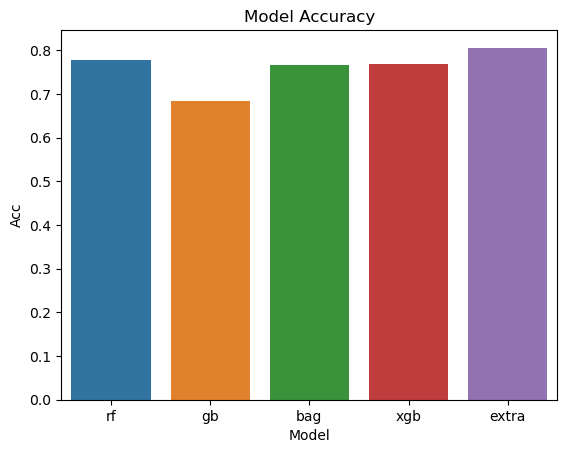

In [64]:
import matplotlib.pyplot as plt 
import seaborn as sns 

mods = list(model_results.keys())
acc = [val[0] for val in list(model_results.values())]
pre = [val[1] for val in list(model_results.values())]
log = [val[2] for val in list(model_results.values())]
auc = [val[3] for val in list(model_results.values())]

# Create barplot using seaborn
sns.barplot(x=mods, y=acc)

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Acc')
plt.title('Model Accuracy')

# Show the plot
plt.show()

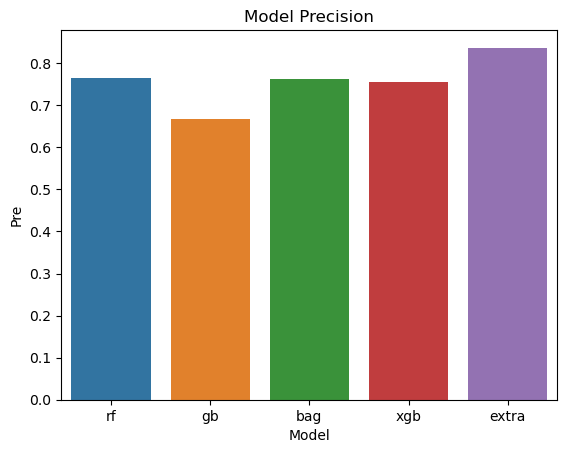

In [65]:
# Create barplot using seaborn
sns.barplot(x=mods, y=pre)

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Pre')
plt.title('Model Precision')

# Show the plot
plt.show()

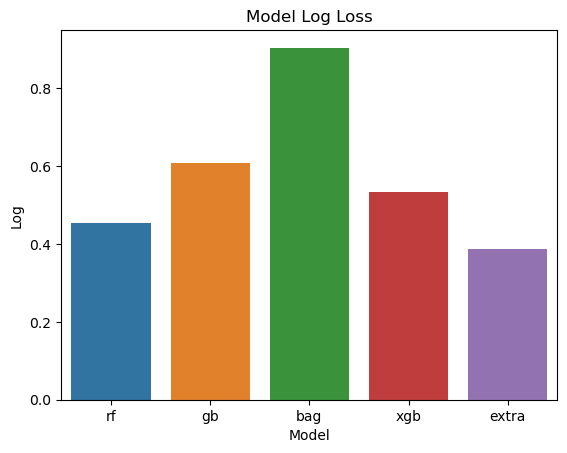

In [66]:
# Create barplot using seaborn
sns.barplot(x=mods, y=log)

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Log')
plt.title('Model Log Loss')

# Show the plot
plt.show()

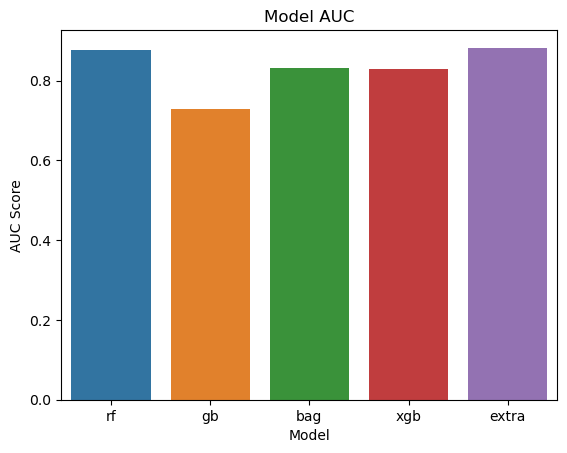

In [67]:
# Create barplot using seaborn
sns.barplot(x=mods, y=auc)

# Add labels and title
plt.xlabel('Model')
plt.ylabel('AUC Score')
plt.title('Model AUC')

# Show the plot
plt.show()

^^^Tabset the above mentioned stuff  

# Hyperpamaters and Probabilistic Thresholds

After finding a model that's fairly compatible with our data, we can experiment with different hyperparameters to better attune the model to our outcome. Keep in mind - the goal is to minimize log loss while maximizing precision. 

We can also use the fact that this is a probabilistic model to further tune our model, by picking a probability threshold (if the probability of one outcome passes a certain threshold, only then is it classified as that outcome).

## Hyperparameter Tuning

Hyperparameter tuning is simple enough - I used Grid Search Cross Validation with 5 folds to evaluate a range of hyperparameters arranged in a parameter grid. 

In [68]:
from sklearn.metrics import make_scorer, precision_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(best_feats_rs, best_targ_rs, random_state=0, test_size=0.2)


# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Define the scoring metrics
scoring = {
    'precision': make_scorer(precision_score),
    'auc': make_scorer(roc_auc_score),
    'log_loss': make_scorer(log_loss, greater_is_better=False, needs_proba=True)
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=extra, param_grid=param_grid, 
                           scoring=scoring, refit='precision', cv=5, verbose=2, n_jobs=-1, 
                           return_train_score=True)

# Fit GridSearchCV to the data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=5, estimator=ExtraTreesClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             refit='precision', return_train_score=True,
             scoring={'auc': make_scorer(roc_auc_score),
                      'log_loss': make_scorer(log_loss, greater_is_better=False, needs_proba=True),
                      'precision': make_scorer(precision_score)},
             verbose=2)

In [69]:
grid_search.best_params_

{'max_depth': None,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [ ]:
extra_final = ExtraTreesClassifier(random_state=42, max_features='log2', min_samples_leaf=1, min_samples_split=2, n_estimators=200)